<a href="https://colab.research.google.com/github/himanshu-tawra/COVID-19-Detector-Flask-App-from-Chest-X-ray-Images-with-Keras-and-Deep-Learning/blob/master/VGG19_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://www.dropbox.com/sh/ogylpn7urqfhkld/AAAa0e2w1v0IuXjkFwjP-p_fa?dl=0

--2020-11-07 17:50:39--  https://www.dropbox.com/sh/ogylpn7urqfhkld/AAAa0e2w1v0IuXjkFwjP-p_fa?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/ogylpn7urqfhkld/AAAa0e2w1v0IuXjkFwjP-p_fa [following]
--2020-11-07 17:50:39--  https://www.dropbox.com/sh/raw/ogylpn7urqfhkld/AAAa0e2w1v0IuXjkFwjP-p_fa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf41435be1e8cc7f04e14232f36.dl.dropboxusercontent.com/zip_download_get/AmJBDJj5je38IdvGDTB4fWIYoAYLagsOod3b2XTDYlYClOJWMwh_TbpQqd5bIWx6cBnMuXL6Qb4zpcmSY3s1YrDmkLyqvrcr8fZZE_R-ZmPvYg [following]
--2020-11-07 17:50:40--  https://ucf41435be1e8cc7f04e14232f36.dl.dropboxusercontent.com/zip_download_get/AmJBDJj5je38IdvGDTB4fWIYoAYLagsOod3b2XTDYlYClOJWMwh_TbpQqd5bIWx6cBnMuXL6Qb4zpcmSY3s1

In [3]:
!unzip AAAa0e2w1v0IuXjkFwjP-p_fa?dl=0

Archive:  AAAa0e2w1v0IuXjkFwjP-p_fa?dl=0
mapname:  conversion of  failed
   creating: Test/
   creating: Train/
   creating: Test/Covid/
   creating: Test/Normal/
   creating: Train/Covid/
   creating: Train/Normal/
 extracting: Train/Covid/AR-1.jpg    
 extracting: Train/Covid/AR-2.jpg    
 extracting: Test/Covid/paving.jpg   
 extracting: Test/Covid/ec083e35.jpg  
 extracting: Test/Covid/d9d6ca9a.jpg  
 extracting: Test/Covid/f6575117.jpg  
 extracting: Test/Covid/e1446fe8.jpg  
 extracting: Test/Covid/f6d980a0.jpg  
 extracting: Test/Covid/f64132c8.jpg  
 extracting: Test/Covid/d009d61f.jpg  
 extracting: Test/Covid/f8335316.jpg  
 extracting: Test/Covid/gr1_lrg-b.jpg  
 extracting: Train/Covid/90986ce4.jpg  
 extracting: Train/Covid/a361d7b7.jpg  
 extracting: Train/Covid/a2eba651.jpg  
 extracting: Train/Covid/c601f50d.jpg  
 extracting: Train/Covid/0a7faa2a.jpg  
 extracting: Train/Covid/1052b0fe.jpg  
 extracting: Train/Covid/7afaaccc.jpg  
 extracting: Train/Covid/c3829ecb.jpg 

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
import os
from keras.applications.vgg19 import VGG19
import keras

In [31]:
IMAGE_SIZE = [224,224]

In [32]:
vgg = VGG19(input_shape= IMAGE_SIZE + [3] , weights='imagenet',include_top=False)

In [33]:
for layer in vgg.layers:
  layer.trainable = False

In [34]:
vgg_output = vgg.output

In [35]:
flatten = Flatten()(vgg_output)
output_layer = Dense(2,activation='softmax')(flatten)

In [36]:
model = Model(inputs = vgg.input,outputs = output_layer)

In [37]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [38]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),  # Low learning rate
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [39]:
training_data_gen = ImageDataGenerator(
    rescale = 1./255.,
    zoom_range = 0.2,
    shear_range = 0.3,
    horizontal_flip = True,
    rotation_range=40, # rotation
    width_shift_range=0.2, # horizontal shift
    height_shift_range=0.2, # vertical shift
)

In [40]:
val_data_gen = ImageDataGenerator(
    rescale = 1./255.
)

In [41]:
training_set = training_data_gen.flow_from_directory(
    'Train/',
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 32
)

Found 251 images belonging to 2 classes.


In [42]:
val_set = val_data_gen.flow_from_directory(
    'Test/',
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 32
)

Found 140 images belonging to 2 classes.


In [43]:
r = model.fit(
    training_set,
    epochs = 100,
    validation_data = val_set,
    validation_steps = len(val_set),
    steps_per_epoch = len(training_set)
    
)

Epoch 1/100
8/8 [==============================] - 12s 1s/step - loss: 0.7275 - accuracy: 0.5219 - val_loss: 0.6808 - val_accuracy: 0.5071
Epoch 2/100
8/8 [==============================] - 11s 1s/step - loss: 0.5845 - accuracy: 0.6773 - val_loss: 0.4175 - val_accuracy: 0.9357
Epoch 3/100
8/8 [==============================] - 11s 1s/step - loss: 0.4436 - accuracy: 0.8606 - val_loss: 0.3652 - val_accuracy: 0.8357
Epoch 4/100
8/8 [==============================] - 11s 1s/step - loss: 0.3700 - accuracy: 0.9044 - val_loss: 0.3016 - val_accuracy: 0.8643
Epoch 5/100
8/8 [==============================] - 11s 1s/step - loss: 0.3219 - accuracy: 0.9363 - val_loss: 0.2347 - val_accuracy: 0.9071
Epoch 6/100
8/8 [==============================] - 11s 1s/step - loss: 0.2869 - accuracy: 0.9203 - val_loss: 0.2767 - val_accuracy: 0.8643
Epoch 7/100
8/8 [==============================] - 11s 1s/step - loss: 0.2494 - accuracy: 0.9402 - val_loss: 0.1982 - val_accuracy: 0.9143
Epoch 8/100
8/8 [==========

In [44]:
test_pred = []
test_actual = []
label_dict = {
    0 : "Covid",
    1 : "Normal"
}

In [45]:
def image_preprocessing(path):
  for filename in os.listdir(path):

    if path == 'Test/Covid':
      filepath = os.path.join(path,filename)
      test_image = image.load_img(filepath,target_size=(224,224))
      image_array = image.img_to_array(test_image)
      image_array = np.expand_dims(image_array,axis = 0)
      rescaled_image = image_array/255. 
      predicted_image = model.predict(rescaled_image)
      predicted_image = label_dict[predicted_image.argmax()]
      test_pred.append(predicted_image)
      test_actual.append('Covid')

    elif path == 'Test/Normal':
      filepath = os.path.join(path,filename)
      test_image = image.load_img(filepath,target_size=(224,224))
      image_array = image.img_to_array(test_image)
      image_array = np.expand_dims(image_array,axis = 0)
      rescaled_image = image_array/255. 
      predicted_image = model.predict(rescaled_image)
      predicted_image = label_dict[predicted_image.argmax()]
      test_pred.append(predicted_image)
      test_actual.append('Normal')




In [46]:
covid_path = 'Test/Covid'
normal_path = 'Test/Normal'

In [47]:
image_preprocessing(covid_path)
image_preprocessing(normal_path)


In [58]:
model.save('vgg19_model.h5')

Confusion Matrix without Normalization


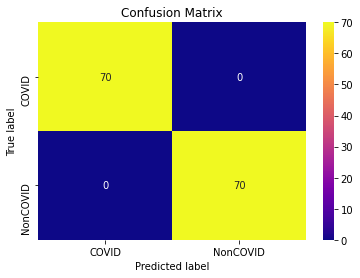

In [67]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(test_actual,test_pred,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig('confusion_mat.png')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

In [68]:
from sklearn.metrics import classification_report
print(classification_report(test_actual, test_pred))

              precision    recall  f1-score   support

       Covid       1.00      1.00      1.00        70
      Normal       1.00      1.00      1.00        70

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140



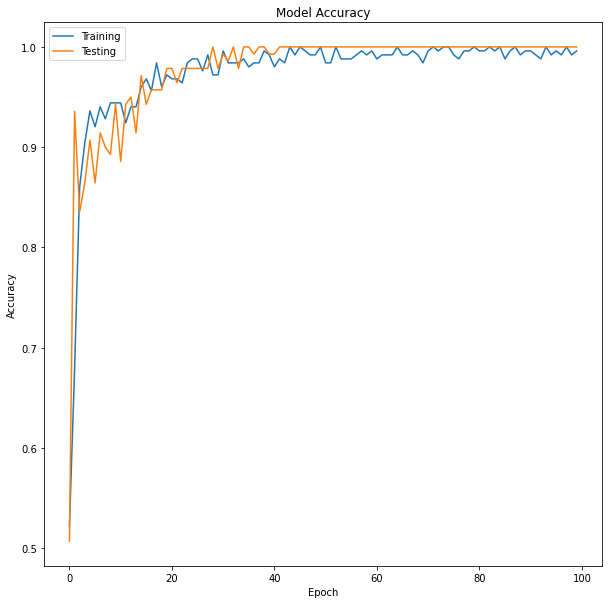

In [69]:

plt.figure(figsize=(10,10))

plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_accuracy.png')
plt.show()

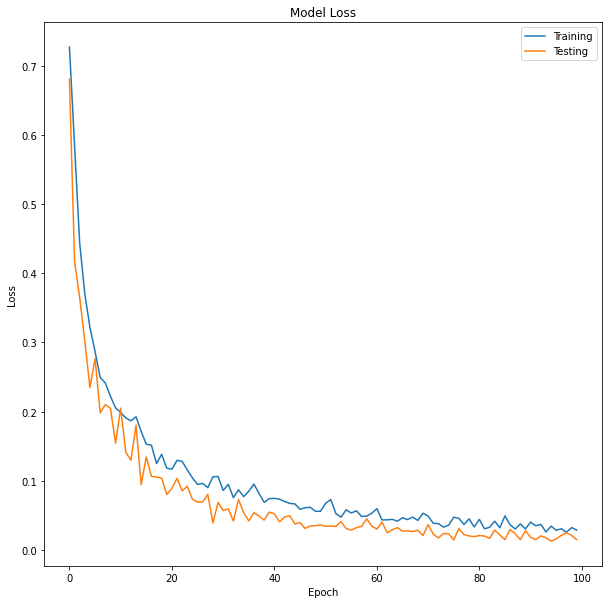

In [70]:
plt.figure(figsize=(10,10))

plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_loss.png')
plt.show()